Question 1 

Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

Taken label using 

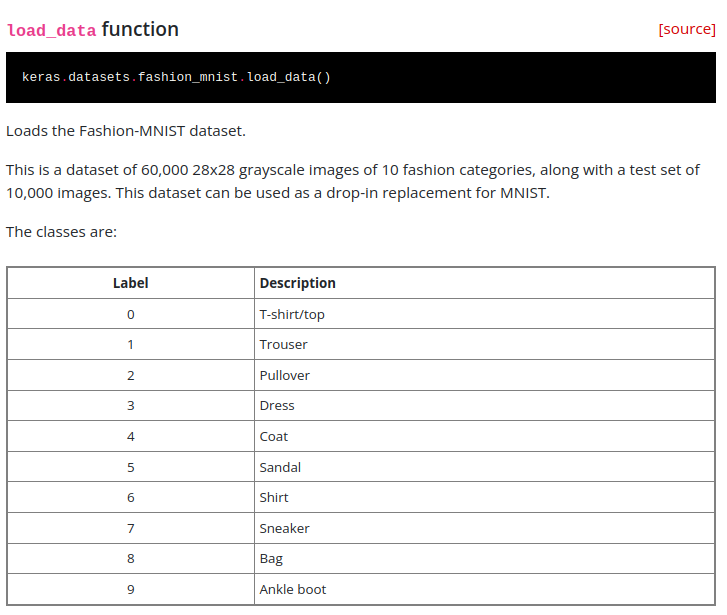


2025-03-17 18:07:31.764066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


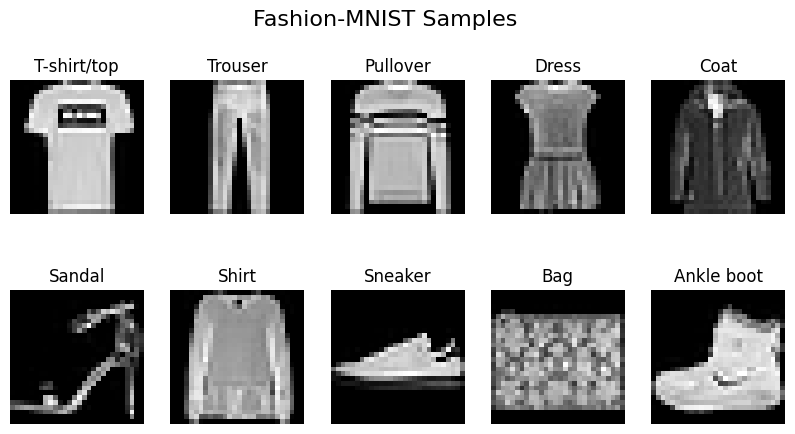

In [3]:

import wandb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.datasets import fashion_mnist


(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


# identified classnames in keras website 

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


sample_images = []

for i in range(10):  # 10 classes in Fashion MNIST
    index = np.where(train_labels == i)[0][0]  # Find the first occurrence of each class
    sample_images.append(train_images[index])
    # sample_labels.append(class_names[i])
    
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Fashion-MNIST Samples", fontsize=16)

for ax, img, label in zip(axes.flat, sample_images, class_names):
    ax.imshow(img, cmap='gray')  # Display grayscale image
    ax.set_title(label)  # Set class name as title
    ax.axis("off")  # Hide axes

# Printing via wandb.ai
# wandb.login()
    
# wandb.init(project="fashion_mnist_sweep",entity="ch24s016-iitm",name='sample images category')

# wandb.log({"Image from each class": [wandb.Image(image, caption=caption) for image, caption in zip(sample_images, class_names)]})



Question 2 

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

In [4]:
# DATA PREPROCESSING

# Load Fashion-MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print(train_images.shape)
print(test_images.shape)

# Normalize pixel values (0-255) -> (0-1)

train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0


train_images_splitted = train_images[:54000]


# One-hot encode labels
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

train_labels_splitted = one_hot_encode(train_labels[:54000])
test_labels = one_hot_encode(test_labels)

val_images = train_images[54000:] # 10% from training dataset is 6000 data point taken as validation dataset from training
val_labels = one_hot_encode(train_labels[54000:]) # 10% from training dataset labels


# all shapes of train , validation and testing datasets 
print('the shape of training images and its training labels',train_images_splitted.shape,len(train_labels_splitted))
print('the shape of validation images and its validation labels',val_images.shape,len(val_labels))
print('the shape of testing images and its testing labels',test_images.shape,len(test_labels))

(60000, 28, 28)
(10000, 28, 28)
the shape of training images and its training labels (54000, 784) 54000
the shape of validation images and its validation labels (6000, 784) 6000
the shape of testing images and its testing labels (10000, 784) 10000


In [5]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_neurons, hidden_layers, output_neurons):
        
        self.layers = [input_neurons] + hidden_layers + [output_neurons]
        self.weights = {}
        self.biases = {}

        # Initialize weights and biases
        for i in range(len(self.layers) - 1):
            self.weights[i] = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            self.biases[i] = np.zeros((1, self.layers[i+1]))


    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Avoid overflow
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        self.activations = {}
        self.z_values = {}

        # Input Layer
        self.activations[0] = X

        # Hidden Layers
        for i in range(len(self.layers) - 2):
            self.z_values[i] = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
            self.activations[i+1] = self.relu(self.z_values[i])

        # Output Layer (Softmax)
        last_layer = len(self.layers) - 2
        self.z_values[last_layer] = np.dot(self.activations[last_layer], self.weights[last_layer]) + self.biases[last_layer]
        self.activations[last_layer+1] = self.softmax(self.z_values[last_layer])

        return self.activations[last_layer+1]

    def train(self, X):
        activations = self.forward(X)
        print('output of feed forward after passing whole network of one data point is ',activations[0])

# Example Usage:

hidden_layers = [128, 64]

# Initialize model
model = NeuralNetwork(input_neurons=784, hidden_layers=hidden_layers, output_neurons=10)

# print('the size of training dataset is',train_images.shape)
# print('the size of training dataset is',test_images.shape)

# Train (Assume train_images is your training data and train_labels is one-hot encoded labels)
model.train(train_images_splitted)


output of feed forward after passing whole network of one data point is  [0.09995777 0.09998101 0.09993682 0.1001009  0.10003339 0.10005441
 0.09992241 0.0999925  0.10002635 0.09999444]


Question 3

Implement the backpropagation algorithm with support for the following optimisation functions

sgd
momentum based gradient descent
nesterov accelerated gradient descent
rmsprop
adam
nadam
(12 marks for the backpropagation framework and 2 marks for each of the optimisation algorithms above)

We will check the code for implementation and ease of use (e.g., how easy it is to add a new optimisation algorithm such as Eve). Note that the code should be flexible enough to work with different batch sizes.

Epoch 1/10 - Train Loss: 0.6219, Train Acc: 0.7685, Val Loss: 0.4576, Val Acc: 0.8347
Epoch 2/10 - Train Loss: 0.3841, Train Acc: 0.8608, Val Loss: 0.3754, Val Acc: 0.8660
Epoch 3/10 - Train Loss: 0.3432, Train Acc: 0.8767, Val Loss: 0.3440, Val Acc: 0.8718
Epoch 4/10 - Train Loss: 0.3199, Train Acc: 0.8824, Val Loss: 0.3473, Val Acc: 0.8678
Epoch 5/10 - Train Loss: 0.3026, Train Acc: 0.8888, Val Loss: 0.3339, Val Acc: 0.8757
Epoch 6/10 - Train Loss: 0.2885, Train Acc: 0.8931, Val Loss: 0.3247, Val Acc: 0.8805
Epoch 7/10 - Train Loss: 0.2772, Train Acc: 0.8971, Val Loss: 0.3524, Val Acc: 0.8690
Epoch 8/10 - Train Loss: 0.2654, Train Acc: 0.9026, Val Loss: 0.3226, Val Acc: 0.8852
Epoch 9/10 - Train Loss: 0.2562, Train Acc: 0.9048, Val Loss: 0.3123, Val Acc: 0.8860
Epoch 10/10 - Train Loss: 0.2476, Train Acc: 0.9079, Val Loss: 0.3323, Val Acc: 0.8777


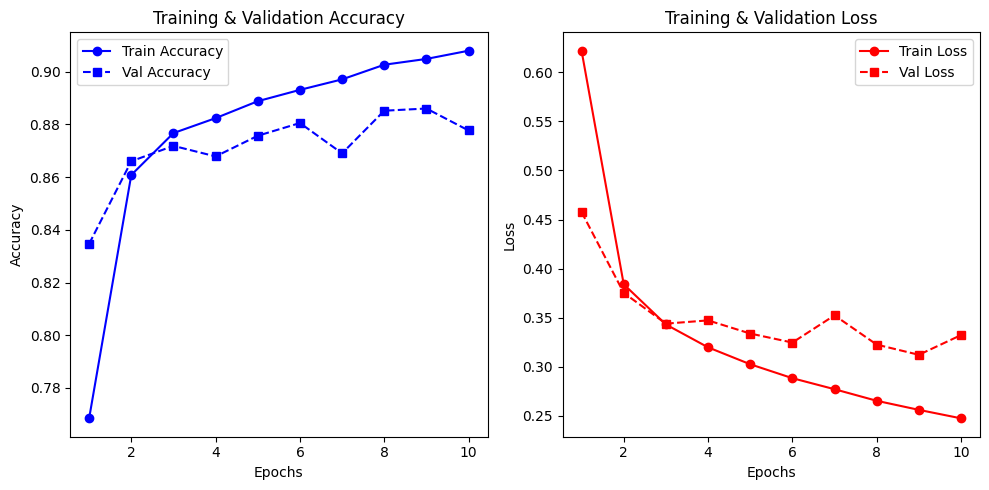

(np.float64(0.9079259259259259),
 np.float64(0.8776666666666667),
 np.float64(0.24757846604457345),
 np.float64(0.3323346577467247))

In [14]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_neurons, hidden_layers, output_neurons, init_wb_method, optimizer, activation, learning_rate, weight_decay, beta1, beta2, epsilon=1e-8):
        self.layers = [input_neurons] + hidden_layers + [output_neurons]
        self.weights = {}
        self.biases = {}
        self.beta1 = beta1
        self.beta2 = beta2
        self.init_wb_method = init_wb_method
        self.epsilon = epsilon
        self.activation = activation
        self.weight_decay = weight_decay

        if init_wb_method == 'random':
            for i in range(len(self.layers) - 1):
                self.weights[i] = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
                self.biases[i] = np.zeros((1, self.layers[i+1]))

        elif init_wb_method == 'xavier':
            for i in range(len(self.layers) - 1):
                r = np.sqrt(6.0 / (self.layers[i] + self.layers[i+1]))
                self.weights[i] = np.random.uniform(-r, r, (self.layers[i], self.layers[i+1]))
                self.biases[i] = np.zeros((1, self.layers[i+1]))

        # Initialize optimizer parameters
        self.optimizer = optimizer
        self.learning_rate = learning_rate

        num_layers = len(self.layers) - 1  # Number of weight layers

        # For Adam, Nadam, and RMSprop
        self.m_w = {i: np.zeros_like(self.weights[i]) for i in range(num_layers)}
        self.v_w = {i: np.zeros_like(self.weights[i]) for i in range(num_layers)}
        self.m_b = {i: np.zeros_like(self.biases[i]) for i in range(num_layers)}
        self.v_b = {i: np.zeros_like(self.biases[i]) for i in range(num_layers)}
        
        # For Adam/Nadam timestep tracking
        self.t = 0

        # For Momentum and Nesterov
        self.velocity_w = {i: np.zeros_like(self.weights[i]) for i in range(num_layers)}
        self.velocity_b = {i: np.zeros_like(self.biases[i]) for i in range(num_layers)}


    # LIST OF ACTIVATION FUNCTIONS 

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Avoid overflow
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def softmax_derivative(self, output, y):
        return output - y
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        sig = self.sigmoid(x)
        return sig * (1 - sig)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def forward(self, X):
        self.activations = {}
        self.z_values = {}

        # Input Layer
        self.activations[0] = X

        # Hidden Layers
        for i in range(len(self.layers) - 2):
            self.z_values[i] = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
            if self.activation == 'relu':
                self.activations[i+1] = self.relu(self.z_values[i])
            elif self.activation == 'sigmoid':
                self.activations[i+1] = self.sigmoid(self.z_values[i])
            elif self.activation == 'tanh':
                self.activations[i+1] = self.tanh(self.z_values[i])

        # Output Layer (Softmax)
        last_layer = len(self.layers) - 2
        self.z_values[last_layer] = np.dot(self.activations[last_layer], self.weights[last_layer]) + self.biases[last_layer]
        self.activations[last_layer+1] = self.softmax(self.z_values[last_layer])

        return self.activations[last_layer+1]
    
    def backward(self, X, y):
        m = X.shape[0]

        # Compute gradient for the output layer
        output = self.activations[len(self.layers) - 1]
        delta = self.softmax_derivative(output, y) / m

        # Backpropagate through the layers
        gradients_w = {}
        gradients_b = {}

        for i in reversed(range(len(self.layers) - 1)):
            gradients_w[i] = np.dot(self.activations[i].T, delta)
            gradients_b[i] = np.sum(delta, axis=0, keepdims=True)

            if i != 0:
                if self.activation == 'relu':
                    delta = np.dot(delta, self.weights[i].T) * self.relu_derivative(self.z_values[i - 1])
                elif self.activation == 'sigmoid':
                    delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(self.z_values[i - 1])
                elif self.activation == 'tanh':
                    delta = np.dot(delta, self.weights[i].T) * self.tanh_derivative(self.z_values[i - 1])

        return gradients_w, gradients_b
    
    def optimization_functions(self, gradients_w, gradients_b):
        num_layers = len(self.layers) - 1

        if self.optimizer == 'sgd':
            for i in range(num_layers):
                self.weights[i] -= self.learning_rate * (gradients_w[i] + self.weight_decay * self.weights[i])
                self.biases[i] -= self.learning_rate * gradients_b[i]  # No weight decay for biases

        elif self.optimizer == 'momentum':
            beta = 0.9
            for i in range(num_layers):
                self.velocity_w[i] = beta * self.velocity_w[i] + (1 - beta) * gradients_w[i]
                self.velocity_b[i] = beta * self.velocity_b[i] + (1 - beta) * gradients_b[i]

                self.weights[i] -= self.learning_rate * (self.velocity_w[i] + self.weight_decay * self.weights[i])
                self.biases[i] -= self.learning_rate * self.velocity_b[i]  # No weight decay for biases

        elif self.optimizer == 'nesterov':
            beta = 0.9
            for i in range(num_layers):
                prev_velocity_w = self.velocity_w[i]
                prev_velocity_b = self.velocity_b[i]

                self.velocity_w[i] = beta * prev_velocity_w + (1 - beta) * gradients_w[i]
                self.velocity_b[i] = beta * prev_velocity_b + (1 - beta) * gradients_b[i]

                self.weights[i] -= self.learning_rate * ((gradients_w[i] + beta * prev_velocity_w) + self.weight_decay * self.weights[i])
                self.biases[i] -= self.learning_rate * (gradients_b[i] + beta * prev_velocity_b)  # No weight decay for biases

        elif self.optimizer == 'rmsprop':
            decay_rate = 0.9
            epsilon = 1e-8
            for i in range(num_layers):
                self.m_w[i] = decay_rate * self.m_w[i] + (1 - decay_rate) * gradients_w[i]**2
                self.m_b[i] = decay_rate * self.m_b[i] + (1 - decay_rate) * gradients_b[i]**2

                self.weights[i] -= self.learning_rate * (gradients_w[i] / (np.sqrt(self.m_w[i]) + epsilon) + self.weight_decay * self.weights[i])
                self.biases[i] -= self.learning_rate * (gradients_b[i] / (np.sqrt(self.m_b[i]) + epsilon))  # No weight decay for biases

        elif self.optimizer == 'adam':
            self.t += 1
            for i in range(num_layers):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * gradients_w[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * gradients_w[i]**2
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * gradients_b[i]
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * gradients_b[i]**2

                m_w_hat = self.m_w[i] / (1 - self.beta1**self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2**self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1**self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2**self.t)

                self.weights[i] -= self.learning_rate * (m_w_hat / (np.sqrt(v_w_hat) + self.epsilon) + self.weight_decay * self.weights[i])
                self.biases[i] -= self.learning_rate * (m_b_hat / (np.sqrt(v_b_hat) + self.epsilon))  # No weight decay for biases

        elif self.optimizer == 'nadam':
            self.t += 1
            for i in range(num_layers):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * gradients_w[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * gradients_w[i]**2
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * gradients_b[i]
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * gradients_b[i]**2

                m_w_hat = self.m_w[i] / (1 - self.beta1**self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2**self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1**self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2**self.t)

                self.weights[i] -= self.learning_rate * ((self.beta1 * m_w_hat + (1 - self.beta1) * gradients_w[i]) / (np.sqrt(v_w_hat) + self.epsilon) + self.weight_decay * self.weights[i])
                self.biases[i] -= self.learning_rate * ((self.beta1 * m_b_hat + (1 - self.beta1) * gradients_b[i]) / (np.sqrt(v_b_hat) + self.epsilon))  # No weight decay for biases
                    
            
    def train(self, X, y, epochs, batch_size, X_val, y_val,loss_function = 'cross_entropy', wb_log=True,plots=False):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            # Shuffle the data
            indices = np.random.permutation(len(X))
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            total_loss = 0
            correct_preds_train = 0

            for i in range(0, len(X), batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # Forward pass
                predictions = self.forward(X_batch)

                # Compute loss (Cross-entropy loss)
                
                if loss_function == "cross_entropy":
                    loss = -np.sum(y_batch * np.log(predictions + 1e-8)) / len(y_batch)  # Avoid log(0)
                elif loss_function == "squared_error":
                    loss = np.sum((y_batch - predictions) ** 2)
                total_loss += loss

                # Compute accuracy for training batch
                y_pred_labels = np.argmax(predictions, axis=1)
                y_true_labels = np.argmax(y_batch, axis=1)
                correct_preds_train += np.sum(y_pred_labels == y_true_labels)

                # Backward pass
                gradients_w, gradients_b = self.backward(X_batch, y_batch)

                # Update weights
                self.optimization_functions(gradients_w, gradients_b)

            # Compute training loss and accuracy
            avg_train_loss = total_loss / (len(X) / batch_size)
            train_losses.append(avg_train_loss)
            train_acc = correct_preds_train / len(X)
            train_accuracies.append(train_acc)

            # Compute validation loss and accuracy
            if X_val is not None and y_val is not None:
                val_predictions = self.forward(X_val)
                val_loss = -np.sum(y_val * np.log(val_predictions + 1e-8)) / len(y_val)
                val_losses.append(val_loss)

                # Compute validation accuracy
                val_pred_labels = np.argmax(val_predictions, axis=1)
                val_true_labels = np.argmax(y_val, axis=1)
                val_acc = np.sum(val_pred_labels == val_true_labels) / len(y_val)
                val_accuracies.append(val_acc)


                if wb_log:
                     wandb.log({'train_acc': train_acc, 'val_acc': val_acc, 'train_loss': avg_train_loss, 'val_loss': val_loss})

                print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            else:
                print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")


        epochs_range = np.arange(1, epochs + 1)

        if(plots):
            plt.figure(figsize=(10, 5))

            # Plot accuracy
            plt.subplot(1, 2, 1)
            plt.plot(epochs_range, train_accuracies, "bo-", label="Train Accuracy")
            plt.plot(epochs_range, val_accuracies, "bs--", label="Val Accuracy")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.title("Training & Validation Accuracy")
            plt.legend()

            # Plot loss
            plt.subplot(1, 2, 2)
            plt.plot(epochs_range, train_losses, "ro-", label="Train Loss")
            plt.plot(epochs_range, val_losses, "rs--", label="Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.title("Training & Validation Loss")
            plt.legend()

            plt.tight_layout()
            plt.show()

        

        return train_acc, val_acc, avg_train_loss ,val_loss


            
    def predict(self, X_test):
        predictions = self.forward(X_test)
        print(predictions)
        # y_pred_labels = np.argmax(predictions, axis=1)
        return predictions
        

# Example Usage:

hidden_layers = [128, 64]
    
# Initialize model
model = NeuralNetwork(input_neurons=784, hidden_layers=hidden_layers, output_neurons=10,init_wb_method='random',activation='tanh',learning_rate=0.001,optimizer='nadam',weight_decay=0.0005,beta1=0.9,beta2=0.99)

# Train (Assume train_images is your training data and train_labels is one-hot encoded labels)
model.train(train_images_splitted,train_labels_splitted,epochs=10,batch_size=32,X_val=val_images,y_val=val_labels,plots=True,wb_log=False)

Question 4

Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()). Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.

number of epochs: 5, 10
number of hidden layers: 3, 4, 5
size of every hidden layer: 32, 64, 128
weight decay (L2 regularisation): 0, 0.0005, 0.5
learning rate: 1e-3, 1 e-4
optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
batch size: 16, 32, 64
weight initialisation: random, Xavier
activation functions: sigmoid, tanh, ReLU
wandb will automatically generate the following plots. Paste these plots below using the "Add Panel to Report" feature. Make sure you use meaningful names for each sweep (e.g. hl_3_bs_16_ac_tanh to indicate that there were 3 hidden layers, batch size was 16 and activation function was ReLU) instead of using the default names (whole-sweep, kind-sweep) given by wandb.

In [ ]:
import wandb

sweep_config = {
    "method": "bayes",  # Use Bayesian optimization for efficient search
    "metric": {"name": "val_loss", "goal": "minimize"},  # Minimize validation loss
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]}
    }
}

def train():
   run = wandb.init()  # Initialize W&B inside function
   config = wandb.config

   wandb.run.name = f"{config.weight_init}_{config.optimizer}_{config.activation}_bs_{config.batch_size}_layers_{config.hidden_layers}_neurons_{config.hidden_size}"

   # Initialize the model
   model = NeuralNetwork(
       input_neurons=784,
       hidden_layers=[config.hidden_size] * config.hidden_layers,
       output_neurons=10,
       optimizer=config.optimizer,
       learning_rate=config.learning_rate,
       init_wb_method=config.weight_init,
       weight_decay = config.weight_decay,
       activation=config.activation,
       beta1=0.9,
       beta2=0.999
   )

   # Train & Evaluate
   train_acc, val_acc, train_loss, val_loss = model.train(train_images_splitted, train_labels_splitted, config.epochs, config.batch_size, val_images, val_labels,plots=False,wb_log=True)

   # Log metrics
   


# Initialize and run the sweep
sweep_id = wandb.sweep(sweep_config, project="fashion_mnist_sweep")
wandb.agent(sweep_id, function=train, count=30)  # Run 30 trials

Create sweep with ID: 2xv177pr
Sweep URL: https://wandb.ai/ch24s016-iitm/fashion_mnist_sweep/sweeps/2xv177pr


wandb: Agent Starting Run: 544uebo1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Loss: 2.4526, Train Acc: 0.1032, Val Loss: 2.3835, Val Acc: 0.1170
Epoch 2/10 - Train Loss: 2.3601, Train Acc: 0.1065, Val Loss: 2.3320, Val Acc: 0.1007
Epoch 3/10 - Train Loss: 2.3248, Train Acc: 0.1009, Val Loss: 2.3124, Val Acc: 0.1003
Epoch 4/10 - Train Loss: 2.3109, Train Acc: 0.0992, Val Loss: 2.3054, Val Acc: 0.1003
Epoch 5/10 - Train Loss: 2.3058, Train Acc: 0.0964, Val Loss: 2.3032, Val Acc: 0.0980
Epoch 6/10 - Train Loss: 2.3040, Train Acc: 0.1001, Val Loss: 2.3026, Val Acc: 0.1072
Epoch 7/10 - Train Loss: 2.3034, Train Acc: 0.1131, Val Loss: 2.3024, Val Acc: 0.0933
Epoch 8/10 - Train Loss: 2.3031, Train Acc: 0.1164, Val Loss: 2.3024, Val Acc: 0.0925
Epoch 9/10 - Train Loss: 2.3031, Train Acc: 0.1013, Val Loss: 2.3024, Val Acc: 0.0953
Epoch 10/10 - Train Loss: 2.3030, Train Acc: 0.1146, Val Loss: 2.3025, Val Acc: 0.0927


train_acc,▃▅▃▂▁▂▇█▃▇
train_loss,█▄▂▁▁▁▁▁▁▁
val_acc,█▃▃▃▃▅▁▁▂▁
val_loss,█▄▂▁▁▁▁▁▁▁
train_acc,0.11457
train_loss,2.30304
val_acc,0.09267
val_loss,2.30245


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oanp1ppi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Loss: 2.4769, Train Acc: 0.1002, Val Loss: 2.4193, Val Acc: 0.0985
Epoch 2/5 - Train Loss: 2.3898, Train Acc: 0.1002, Val Loss: 2.3601, Val Acc: 0.0985
Epoch 3/5 - Train Loss: 2.3462, Train Acc: 0.1002, Val Loss: 2.3307, Val Acc: 0.0985
Epoch 4/5 - Train Loss: 2.3244, Train Acc: 0.1002, Val Loss: 2.3162, Val Acc: 0.0985
Epoch 5/5 - Train Loss: 2.3137, Train Acc: 0.1002, Val Loss: 2.3092, Val Acc: 0.0985


train_acc,▁▁▁▁▁
train_loss,█▄▂▁▁
val_acc,▁▁▁▁▁
val_loss,█▄▂▁▁
train_acc,0.10017
train_loss,2.31366
val_acc,0.0985
val_loss,2.30915


wandb: Agent Starting Run: o0ge9826 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Loss: 2.3498, Train Acc: 0.0996, Val Loss: 2.3453, Val Acc: 0.1032
Epoch 2/5 - Train Loss: 2.3413, Train Acc: 0.0996, Val Loss: 2.3377, Val Acc: 0.1032
Epoch 3/5 - Train Loss: 2.3345, Train Acc: 0.0996, Val Loss: 2.3316, Val Acc: 0.1032
Epoch 4/5 - Train Loss: 2.3290, Train Acc: 0.0996, Val Loss: 2.3267, Val Acc: 0.1032
Epoch 5/5 - Train Loss: 2.3246, Train Acc: 0.0996, Val Loss: 2.3226, Val Acc: 0.1032


train_acc,▁▁▁▁▁
train_loss,█▆▄▂▁
val_acc,▁▁▁▁▁
val_loss,█▆▄▂▁
train_acc,0.09965
train_loss,2.32458
val_acc,0.10317
val_loss,2.32263


wandb: Agent Starting Run: wtfqg87y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 1.7689, Train Acc: 0.2255, Val Loss: 1.4221, Val Acc: 0.3643
Epoch 2/10 - Train Loss: 1.0556, Train Acc: 0.5307, Val Loss: 0.8453, Val Acc: 0.6213
Epoch 3/10 - Train Loss: 0.7638, Train Acc: 0.6765, Val Loss: 0.7074, Val Acc: 0.7287
Epoch 4/10 - Train Loss: 0.6350, Train Acc: 0.7628, Val Loss: 0.6394, Val Acc: 0.7610
Epoch 5/10 - Train Loss: 0.5773, Train Acc: 0.7972, Val Loss: 0.5876, Val Acc: 0.8047
Epoch 6/10 - Train Loss: 0.5351, Train Acc: 0.8236, Val Loss: 0.5630, Val Acc: 0.8292
Epoch 7/10 - Train Loss: 0.4994, Train Acc: 0.8391, Val Loss: 0.5216, Val Acc: 0.8380
Epoch 8/10 - Train Loss: 0.4732, Train Acc: 0.8485, Val Loss: 0.5136, Val Acc: 0.8398
Epoch 9/10 - Train Loss: 0.4424, Train Acc: 0.8561, Val Loss: 0.4633, Val Acc: 0.8523
Epoch 10/10 - Train Loss: 0.4150, Train Acc: 0.8643, Val Loss: 0.4567, Val Acc: 0.8498


train_acc,▁▄▆▇▇█████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▅▆▇▇█████
val_loss,█▄▃▂▂▂▁▁▁▁
train_acc,0.86428
train_loss,0.41502
val_acc,0.84983
val_loss,0.4567


wandb: Agent Starting Run: w7f35cca with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 1.2581, Train Acc: 0.4360, Val Loss: 0.7524, Val Acc: 0.7025
Epoch 2/10 - Train Loss: 0.6718, Train Acc: 0.7415, Val Loss: 0.5885, Val Acc: 0.7995
Epoch 3/10 - Train Loss: 0.5270, Train Acc: 0.8115, Val Loss: 0.4870, Val Acc: 0.8252
Epoch 4/10 - Train Loss: 0.4312, Train Acc: 0.8532, Val Loss: 0.4426, Val Acc: 0.8408
Epoch 5/10 - Train Loss: 0.3857, Train Acc: 0.8651, Val Loss: 0.4150, Val Acc: 0.8563
Epoch 6/10 - Train Loss: 0.3621, Train Acc: 0.8719, Val Loss: 0.3888, Val Acc: 0.8600
Epoch 7/10 - Train Loss: 0.3458, Train Acc: 0.8775, Val Loss: 0.3758, Val Acc: 0.8725
Epoch 8/10 - Train Loss: 0.3322, Train Acc: 0.8812, Val Loss: 0.3686, Val Acc: 0.8692
Epoch 9/10 - Train Loss: 0.3217, Train Acc: 0.8845, Val Loss: 0.3604, Val Acc: 0.8723
Epoch 10/10 - Train Loss: 0.3105, Train Acc: 0.8887, Val Loss: 0.3697, Val Acc: 0.8673


train_acc,▁▆▇▇██████
train_loss,█▄▃▂▂▁▁▁▁▁
val_acc,▁▅▆▇▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
train_acc,0.88869
train_loss,0.31045
val_acc,0.86733
val_loss,0.36966


wandb: Agent Starting Run: 4nv5iy0x with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 1.3210, Train Acc: 0.4626, Val Loss: 0.7280, Val Acc: 0.7322
Epoch 2/10 - Train Loss: 0.6697, Train Acc: 0.7628, Val Loss: 0.6427, Val Acc: 0.7782
Epoch 3/10 - Train Loss: 0.6377, Train Acc: 0.7729, Val Loss: 0.6080, Val Acc: 0.7780
Epoch 4/10 - Train Loss: 0.6206, Train Acc: 0.7810, Val Loss: 0.6012, Val Acc: 0.7893
Epoch 5/10 - Train Loss: 0.6089, Train Acc: 0.7845, Val Loss: 0.5771, Val Acc: 0.8032
Epoch 6/10 - Train Loss: 0.5968, Train Acc: 0.7922, Val Loss: 0.5693, Val Acc: 0.7965
Epoch 7/10 - Train Loss: 0.5864, Train Acc: 0.7965, Val Loss: 0.6001, Val Acc: 0.7898
Epoch 8/10 - Train Loss: 0.5787, Train Acc: 0.7996, Val Loss: 0.5428, Val Acc: 0.8145
Epoch 9/10 - Train Loss: 0.5659, Train Acc: 0.8038, Val Loss: 0.5467, Val Acc: 0.8093
Epoch 10/10 - Train Loss: 0.5603, Train Acc: 0.8070, Val Loss: 0.5827, Val Acc: 0.7813


train_acc,▁▇▇▇██████
train_loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▅▅▆▇▆▆██▅
val_loss,█▅▃▃▂▂▃▁▁▃
train_acc,0.80702
train_loss,0.56032
val_acc,0.78133
val_loss,0.58275


wandb: Agent Starting Run: cryikz96 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 1.0064, Train Acc: 0.5869, Val Loss: 0.8147, Val Acc: 0.6982
Epoch 2/10 - Train Loss: 0.7496, Train Acc: 0.7236, Val Loss: 0.6497, Val Acc: 0.7620
Epoch 3/10 - Train Loss: 0.5945, Train Acc: 0.7777, Val Loss: 0.6251, Val Acc: 0.7593
Epoch 4/10 - Train Loss: 0.5069, Train Acc: 0.8148, Val Loss: 0.4768, Val Acc: 0.8303
Epoch 5/10 - Train Loss: 0.4461, Train Acc: 0.8382, Val Loss: 0.4442, Val Acc: 0.8430
Epoch 6/10 - Train Loss: 0.4044, Train Acc: 0.8546, Val Loss: 0.4261, Val Acc: 0.8462
Epoch 7/10 - Train Loss: 0.3822, Train Acc: 0.8626, Val Loss: 0.4385, Val Acc: 0.8432
Epoch 8/10 - Train Loss: 0.3657, Train Acc: 0.8682, Val Loss: 0.4262, Val Acc: 0.8450
Epoch 9/10 - Train Loss: 0.3483, Train Acc: 0.8723, Val Loss: 0.3861, Val Acc: 0.8572
Epoch 10/10 - Train Loss: 0.3364, Train Acc: 0.8776, Val Loss: 0.3621, Val Acc: 0.8750


train_acc,▁▄▆▆▇▇████
train_loss,█▅▄▃▂▂▁▁▁▁
val_acc,▁▄▃▆▇▇▇▇▇█
val_loss,█▅▅▃▂▂▂▂▁▁
train_acc,0.87761
train_loss,0.33639
val_acc,0.875
val_loss,0.36209


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: na7ckxeb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 1.0185, Train Acc: 0.5802, Val Loss: 0.6076, Val Acc: 0.7775
Epoch 2/10 - Train Loss: 0.5965, Train Acc: 0.7768, Val Loss: 0.5654, Val Acc: 0.7847
Epoch 3/10 - Train Loss: 0.4865, Train Acc: 0.8270, Val Loss: 0.4763, Val Acc: 0.8262
Epoch 4/10 - Train Loss: 0.4085, Train Acc: 0.8540, Val Loss: 0.4162, Val Acc: 0.8528
Epoch 5/10 - Train Loss: 0.3766, Train Acc: 0.8649, Val Loss: 0.3829, Val Acc: 0.8627
Epoch 6/10 - Train Loss: 0.3528, Train Acc: 0.8729, Val Loss: 0.3945, Val Acc: 0.8655
Epoch 7/10 - Train Loss: 0.3390, Train Acc: 0.8771, Val Loss: 0.3918, Val Acc: 0.8600
Epoch 8/10 - Train Loss: 0.3223, Train Acc: 0.8827, Val Loss: 0.3458, Val Acc: 0.8783
Epoch 9/10 - Train Loss: 0.3143, Train Acc: 0.8866, Val Loss: 0.3559, Val Acc: 0.8775
Epoch 10/10 - Train Loss: 0.3037, Train Acc: 0.8875, Val Loss: 0.3502, Val Acc: 0.8743


train_acc,▁▅▇▇▇█████
train_loss,█▄▃▂▂▁▁▁▁▁
val_acc,▁▁▄▆▇▇▇███
val_loss,█▇▄▃▂▂▂▁▁▁
train_acc,0.88754
train_loss,0.30368
val_acc,0.87433
val_loss,0.35018


wandb: Agent Starting Run: q9e860mp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 1.0163, Train Acc: 0.5816, Val Loss: 0.8462, Val Acc: 0.7012
Epoch 2/10 - Train Loss: 0.7324, Train Acc: 0.7305, Val Loss: 0.6400, Val Acc: 0.7715
Epoch 3/10 - Train Loss: 0.6076, Train Acc: 0.7682, Val Loss: 0.6252, Val Acc: 0.7733
Epoch 4/10 - Train Loss: 0.5496, Train Acc: 0.7908, Val Loss: 0.5678, Val Acc: 0.7783
Epoch 5/10 - Train Loss: 0.5127, Train Acc: 0.8038, Val Loss: 0.5162, Val Acc: 0.8132
Epoch 6/10 - Train Loss: 0.4792, Train Acc: 0.8206, Val Loss: 0.4889, Val Acc: 0.8257
Epoch 7/10 - Train Loss: 0.4527, Train Acc: 0.8358, Val Loss: 0.4556, Val Acc: 0.8330
Epoch 8/10 - Train Loss: 0.4307, Train Acc: 0.8453, Val Loss: 0.4663, Val Acc: 0.8370
Epoch 9/10 - Train Loss: 0.4084, Train Acc: 0.8557, Val Loss: 0.4288, Val Acc: 0.8477
Epoch 10/10 - Train Loss: 0.3773, Train Acc: 0.8661, Val Loss: 0.4094, Val Acc: 0.8625


train_acc,▁▅▆▆▆▇▇▇██
train_loss,█▅▄▃▂▂▂▂▁▁
val_acc,▁▄▄▄▆▆▇▇▇█
val_loss,█▅▄▄▃▂▂▂▁▁
train_acc,0.86609
train_loss,0.37727
val_acc,0.8625
val_loss,0.40936


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q5kwkizb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 0.8945, Train Acc: 0.6451, Val Loss: 0.7138, Val Acc: 0.7513
Epoch 2/10 - Train Loss: 0.6139, Train Acc: 0.7658, Val Loss: 0.5488, Val Acc: 0.7908
Epoch 3/10 - Train Loss: 0.5400, Train Acc: 0.7907, Val Loss: 0.5493, Val Acc: 0.7852
Epoch 4/10 - Train Loss: 0.4980, Train Acc: 0.8103, Val Loss: 0.4954, Val Acc: 0.8082
Epoch 5/10 - Train Loss: 0.4592, Train Acc: 0.8298, Val Loss: 0.6081, Val Acc: 0.7873
Epoch 6/10 - Train Loss: 0.4087, Train Acc: 0.8512, Val Loss: 0.4223, Val Acc: 0.8497
Epoch 7/10 - Train Loss: 0.3694, Train Acc: 0.8668, Val Loss: 0.4237, Val Acc: 0.8540
Epoch 8/10 - Train Loss: 0.3461, Train Acc: 0.8769, Val Loss: 0.3723, Val Acc: 0.8723
Epoch 9/10 - Train Loss: 0.3299, Train Acc: 0.8816, Val Loss: 0.3744, Val Acc: 0.8750
Epoch 10/10 - Train Loss: 0.3176, Train Acc: 0.8860, Val Loss: 0.3909, Val Acc: 0.8610


train_acc,▁▅▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▃▃▄▃▇▇██▇
val_loss,█▅▅▄▆▂▂▁▁▁
train_acc,0.886
train_loss,0.31764
val_acc,0.861
val_loss,0.39088


wandb: Agent Starting Run: kbtn9baw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 0.9245, Train Acc: 0.6318, Val Loss: 0.7347, Val Acc: 0.7488
Epoch 2/10 - Train Loss: 0.6305, Train Acc: 0.7634, Val Loss: 0.5889, Val Acc: 0.7828
Epoch 3/10 - Train Loss: 0.5589, Train Acc: 0.7882, Val Loss: 0.5394, Val Acc: 0.8000
Epoch 4/10 - Train Loss: 0.5183, Train Acc: 0.8102, Val Loss: 0.5218, Val Acc: 0.8050
Epoch 5/10 - Train Loss: 0.4872, Train Acc: 0.8237, Val Loss: 0.4744, Val Acc: 0.8333
Epoch 6/10 - Train Loss: 0.4659, Train Acc: 0.8350, Val Loss: 0.4632, Val Acc: 0.8327
Epoch 7/10 - Train Loss: 0.4470, Train Acc: 0.8417, Val Loss: 0.4535, Val Acc: 0.8463
Epoch 8/10 - Train Loss: 0.4242, Train Acc: 0.8513, Val Loss: 0.5076, Val Acc: 0.8270
Epoch 9/10 - Train Loss: 0.4093, Train Acc: 0.8571, Val Loss: 0.4193, Val Acc: 0.8522
Epoch 10/10 - Train Loss: 0.3921, Train Acc: 0.8616, Val Loss: 0.4420, Val Acc: 0.8487


train_acc,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁▃▄▅▇▇█▆██
val_loss,█▅▄▃▂▂▂▃▁▂
train_acc,0.86159
train_loss,0.3921
val_acc,0.84867
val_loss,0.44199


wandb: Agent Starting Run: lnul6dt5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 1.4604, Train Acc: 0.3216, Val Loss: 1.0538, Val Acc: 0.4957
Epoch 2/10 - Train Loss: 0.9194, Train Acc: 0.5823, Val Loss: 0.7676, Val Acc: 0.7098
Epoch 3/10 - Train Loss: 0.6833, Train Acc: 0.7268, Val Loss: 0.6668, Val Acc: 0.7460
Epoch 4/10 - Train Loss: 0.5978, Train Acc: 0.7826, Val Loss: 0.6195, Val Acc: 0.7703
Epoch 5/10 - Train Loss: 0.5444, Train Acc: 0.8058, Val Loss: 0.5496, Val Acc: 0.8130
Epoch 6/10 - Train Loss: 0.5050, Train Acc: 0.8264, Val Loss: 0.4937, Val Acc: 0.8357
Epoch 7/10 - Train Loss: 0.4597, Train Acc: 0.8478, Val Loss: 0.4726, Val Acc: 0.8420
Epoch 8/10 - Train Loss: 0.4215, Train Acc: 0.8565, Val Loss: 0.4406, Val Acc: 0.8545
Epoch 9/10 - Train Loss: 0.4023, Train Acc: 0.8614, Val Loss: 0.4234, Val Acc: 0.8547
Epoch 10/10 - Train Loss: 0.3848, Train Acc: 0.8659, Val Loss: 0.4089, Val Acc: 0.8615


train_acc,▁▄▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▅▆▆▇█████
val_loss,█▅▄▃▃▂▂▁▁▁
train_acc,0.86587
train_loss,0.38478
val_acc,0.8615
val_loss,0.40892


wandb: Agent Starting Run: icdx8nn4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 1.0365, Train Acc: 0.5706, Val Loss: 0.8503, Val Acc: 0.6853
Epoch 2/10 - Train Loss: 0.7920, Train Acc: 0.7126, Val Loss: 0.7565, Val Acc: 0.7162
Epoch 3/10 - Train Loss: 0.7089, Train Acc: 0.7401, Val Loss: 0.6704, Val Acc: 0.7340
Epoch 4/10 - Train Loss: 0.6565, Train Acc: 0.7561, Val Loss: 0.6494, Val Acc: 0.7600
Epoch 5/10 - Train Loss: 0.6303, Train Acc: 0.7666, Val Loss: 0.6105, Val Acc: 0.7798
Epoch 6/10 - Train Loss: 0.6119, Train Acc: 0.7720, Val Loss: 0.6374, Val Acc: 0.7597
Epoch 7/10 - Train Loss: 0.5971, Train Acc: 0.7808, Val Loss: 0.6065, Val Acc: 0.7785
Epoch 8/10 - Train Loss: 0.5800, Train Acc: 0.7851, Val Loss: 0.5647, Val Acc: 0.7970
Epoch 9/10 - Train Loss: 0.5662, Train Acc: 0.7917, Val Loss: 0.5497, Val Acc: 0.8008
Epoch 10/10 - Train Loss: 0.5530, Train Acc: 0.7955, Val Loss: 0.5539, Val Acc: 0.7982


train_acc,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▂▁▁▁
val_acc,▁▃▄▆▇▆▇███
val_loss,█▆▄▃▂▃▂▁▁▁
train_acc,0.7955
train_loss,0.55303
val_acc,0.79817
val_loss,0.55389


wandb: Agent Starting Run: biywsvej with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 0.8537, Train Acc: 0.6709, Val Loss: 0.5980, Val Acc: 0.7827
Epoch 2/10 - Train Loss: 0.5375, Train Acc: 0.8026, Val Loss: 0.5109, Val Acc: 0.8035
Epoch 3/10 - Train Loss: 0.4371, Train Acc: 0.8449, Val Loss: 0.4454, Val Acc: 0.8405
Epoch 4/10 - Train Loss: 0.3934, Train Acc: 0.8591, Val Loss: 0.3925, Val Acc: 0.8595
Epoch 5/10 - Train Loss: 0.3587, Train Acc: 0.8690, Val Loss: 0.3633, Val Acc: 0.8683
Epoch 6/10 - Train Loss: 0.3400, Train Acc: 0.8769, Val Loss: 0.3644, Val Acc: 0.8682
Epoch 7/10 - Train Loss: 0.3217, Train Acc: 0.8840, Val Loss: 0.3570, Val Acc: 0.8750
Epoch 8/10 - Train Loss: 0.3069, Train Acc: 0.8890, Val Loss: 0.3359, Val Acc: 0.8785
Epoch 9/10 - Train Loss: 0.2934, Train Acc: 0.8926, Val Loss: 0.3397, Val Acc: 0.8732
Epoch 10/10 - Train Loss: 0.2821, Train Acc: 0.8969, Val Loss: 0.3563, Val Acc: 0.8740


train_acc,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▃▅▇▇▇████
val_loss,█▆▄▃▂▂▂▁▁▂
train_acc,0.89689
train_loss,0.28206
val_acc,0.874
val_loss,0.35633


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x5i0y1gp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 0.9231, Train Acc: 0.6270, Val Loss: 0.7130, Val Acc: 0.7427
Epoch 2/10 - Train Loss: 0.6506, Train Acc: 0.7557, Val Loss: 0.5911, Val Acc: 0.7817
Epoch 3/10 - Train Loss: 0.5546, Train Acc: 0.7877, Val Loss: 0.6138, Val Acc: 0.7617
Epoch 4/10 - Train Loss: 0.4956, Train Acc: 0.8111, Val Loss: 0.4898, Val Acc: 0.8168
Epoch 5/10 - Train Loss: 0.4446, Train Acc: 0.8368, Val Loss: 0.4594, Val Acc: 0.8330
Epoch 6/10 - Train Loss: 0.4120, Train Acc: 0.8514, Val Loss: 0.4224, Val Acc: 0.8557
Epoch 7/10 - Train Loss: 0.3843, Train Acc: 0.8640, Val Loss: 0.3993, Val Acc: 0.8608
Epoch 8/10 - Train Loss: 0.3566, Train Acc: 0.8712, Val Loss: 0.4112, Val Acc: 0.8578
Epoch 9/10 - Train Loss: 0.3310, Train Acc: 0.8812, Val Loss: 0.3944, Val Acc: 0.8552
Epoch 10/10 - Train Loss: 0.3165, Train Acc: 0.8858, Val Loss: 0.3781, Val Acc: 0.8667


train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▃▂▅▆▇██▇█
val_loss,█▅▆▃▃▂▁▂▁▁
train_acc,0.88581
train_loss,0.31646
val_acc,0.86667
val_loss,0.37805


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i31fo6qj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 0.9666, Train Acc: 0.6056, Val Loss: 0.7854, Val Acc: 0.7277
Epoch 2/10 - Train Loss: 0.7013, Train Acc: 0.7401, Val Loss: 0.6161, Val Acc: 0.7785
Epoch 3/10 - Train Loss: 0.5765, Train Acc: 0.7806, Val Loss: 0.5478, Val Acc: 0.7928
Epoch 4/10 - Train Loss: 0.4877, Train Acc: 0.8226, Val Loss: 0.4539, Val Acc: 0.8373
Epoch 5/10 - Train Loss: 0.4198, Train Acc: 0.8499, Val Loss: 0.3975, Val Acc: 0.8603
Epoch 6/10 - Train Loss: 0.3726, Train Acc: 0.8661, Val Loss: 0.3858, Val Acc: 0.8630
Epoch 7/10 - Train Loss: 0.3441, Train Acc: 0.8752, Val Loss: 0.3711, Val Acc: 0.8660
Epoch 8/10 - Train Loss: 0.3248, Train Acc: 0.8838, Val Loss: 0.3591, Val Acc: 0.8747
Epoch 9/10 - Train Loss: 0.3118, Train Acc: 0.8874, Val Loss: 0.3526, Val Acc: 0.8730
Epoch 10/10 - Train Loss: 0.2973, Train Acc: 0.8912, Val Loss: 0.3527, Val Acc: 0.8788


train_acc,▁▄▅▆▇▇████
train_loss,█▅▄▃▂▂▁▁▁▁
val_acc,▁▃▄▆▇▇▇███
val_loss,█▅▄▃▂▂▁▁▁▁
train_acc,0.89122
train_loss,0.29726
val_acc,0.87883
val_loss,0.35274


wandb: Agent Starting Run: c9o33q87 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 1.4729, Train Acc: 0.3282, Val Loss: 0.9155, Val Acc: 0.5843
Epoch 2/10 - Train Loss: 0.7325, Train Acc: 0.7170, Val Loss: 0.6172, Val Acc: 0.7870
Epoch 3/10 - Train Loss: 0.5362, Train Acc: 0.8189, Val Loss: 0.4846, Val Acc: 0.8415
Epoch 4/10 - Train Loss: 0.4552, Train Acc: 0.8490, Val Loss: 0.4516, Val Acc: 0.8482
Epoch 5/10 - Train Loss: 0.4173, Train Acc: 0.8616, Val Loss: 0.4463, Val Acc: 0.8438
Epoch 6/10 - Train Loss: 0.3840, Train Acc: 0.8708, Val Loss: 0.3836, Val Acc: 0.8680
Epoch 7/10 - Train Loss: 0.3591, Train Acc: 0.8779, Val Loss: 0.3930, Val Acc: 0.8680
Epoch 8/10 - Train Loss: 0.3404, Train Acc: 0.8823, Val Loss: 0.3720, Val Acc: 0.8707
Epoch 9/10 - Train Loss: 0.3280, Train Acc: 0.8858, Val Loss: 0.3769, Val Acc: 0.8702
Epoch 10/10 - Train Loss: 0.3131, Train Acc: 0.8907, Val Loss: 0.3807, Val Acc: 0.8718


train_acc,▁▆▇▇██████
train_loss,█▄▂▂▂▁▁▁▁▁
val_acc,▁▆▇▇▇█████
val_loss,█▄▂▂▂▁▁▁▁▁
train_acc,0.89069
train_loss,0.31311
val_acc,0.87183
val_loss,0.38069


wandb: Agent Starting Run: 897pi60o with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 1.0087, Train Acc: 0.5886, Val Loss: 0.7961, Val Acc: 0.7143
Epoch 2/10 - Train Loss: 0.7183, Train Acc: 0.7356, Val Loss: 0.6379, Val Acc: 0.7675
Epoch 3/10 - Train Loss: 0.6136, Train Acc: 0.7692, Val Loss: 0.6335, Val Acc: 0.7647
Epoch 4/10 - Train Loss: 0.5548, Train Acc: 0.7916, Val Loss: 0.5255, Val Acc: 0.8028
Epoch 5/10 - Train Loss: 0.5149, Train Acc: 0.8054, Val Loss: 0.5073, Val Acc: 0.8113
Epoch 6/10 - Train Loss: 0.4874, Train Acc: 0.8197, Val Loss: 0.5460, Val Acc: 0.7857
Epoch 7/10 - Train Loss: 0.4518, Train Acc: 0.8380, Val Loss: 0.4925, Val Acc: 0.8348
Epoch 8/10 - Train Loss: 0.4085, Train Acc: 0.8580, Val Loss: 0.4471, Val Acc: 0.8550
Epoch 9/10 - Train Loss: 0.3770, Train Acc: 0.8686, Val Loss: 0.4896, Val Acc: 0.8287
Epoch 10/10 - Train Loss: 0.3598, Train Acc: 0.8750, Val Loss: 0.3877, Val Acc: 0.8657


train_acc,▁▅▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▃▃▅▅▄▇█▆█
val_loss,█▅▅▃▃▄▃▂▃▁
train_acc,0.87504
train_loss,0.35975
val_acc,0.86567
val_loss,0.38772


wandb: Agent Starting Run: ner3zsie with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 1.3441, Train Acc: 0.4006, Val Loss: 0.7049, Val Acc: 0.7595
Epoch 2/10 - Train Loss: 0.6198, Train Acc: 0.7827, Val Loss: 0.5481, Val Acc: 0.8227
Epoch 3/10 - Train Loss: 0.4723, Train Acc: 0.8377, Val Loss: 0.4500, Val Acc: 0.8398
Epoch 4/10 - Train Loss: 0.4149, Train Acc: 0.8546, Val Loss: 0.4201, Val Acc: 0.8445
Epoch 5/10 - Train Loss: 0.3867, Train Acc: 0.8616, Val Loss: 0.3933, Val Acc: 0.8580
Epoch 6/10 - Train Loss: 0.3604, Train Acc: 0.8719, Val Loss: 0.3747, Val Acc: 0.8658
Epoch 7/10 - Train Loss: 0.3462, Train Acc: 0.8761, Val Loss: 0.3783, Val Acc: 0.8643
Epoch 8/10 - Train Loss: 0.3310, Train Acc: 0.8819, Val Loss: 0.3661, Val Acc: 0.8690
Epoch 9/10 - Train Loss: 0.3184, Train Acc: 0.8870, Val Loss: 0.3537, Val Acc: 0.8730
Epoch 10/10 - Train Loss: 0.3077, Train Acc: 0.8903, Val Loss: 0.3697, Val Acc: 0.8728


train_acc,▁▆▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▅▆▆▇█▇███
val_loss,█▅▃▂▂▁▁▁▁▁
train_acc,0.89026
train_loss,0.30773
val_acc,0.87283
val_loss,0.36969


wandb: Agent Starting Run: us7vqyqc with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 0.8229, Train Acc: 0.6769, Val Loss: 0.5663, Val Acc: 0.7958
Epoch 2/10 - Train Loss: 0.4948, Train Acc: 0.8215, Val Loss: 0.5033, Val Acc: 0.8230
Epoch 3/10 - Train Loss: 0.4163, Train Acc: 0.8513, Val Loss: 0.3898, Val Acc: 0.8615
Epoch 4/10 - Train Loss: 0.3782, Train Acc: 0.8645, Val Loss: 0.3983, Val Acc: 0.8655
Epoch 5/10 - Train Loss: 0.3531, Train Acc: 0.8730, Val Loss: 0.3603, Val Acc: 0.8692
Epoch 6/10 - Train Loss: 0.3312, Train Acc: 0.8809, Val Loss: 0.4031, Val Acc: 0.8603
Epoch 7/10 - Train Loss: 0.3165, Train Acc: 0.8850, Val Loss: 0.3631, Val Acc: 0.8752
Epoch 8/10 - Train Loss: 0.3008, Train Acc: 0.8899, Val Loss: 0.3817, Val Acc: 0.8655
Epoch 9/10 - Train Loss: 0.2901, Train Acc: 0.8931, Val Loss: 0.3312, Val Acc: 0.8770
Epoch 10/10 - Train Loss: 0.2782, Train Acc: 0.8971, Val Loss: 0.3400, Val Acc: 0.8757


train_acc,▁▆▇▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▃▇▇▇▇█▇██
val_loss,█▆▃▃▂▃▂▃▁▁
train_acc,0.89706
train_loss,0.2782
val_acc,0.87567
val_loss,0.34002


wandb: Agent Starting Run: q52cdugi with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 0.9758, Train Acc: 0.6061, Val Loss: 0.7729, Val Acc: 0.7228
Epoch 2/10 - Train Loss: 0.6444, Train Acc: 0.7585, Val Loss: 0.5972, Val Acc: 0.7810
Epoch 3/10 - Train Loss: 0.5447, Train Acc: 0.7961, Val Loss: 0.5214, Val Acc: 0.8152
Epoch 4/10 - Train Loss: 0.4930, Train Acc: 0.8211, Val Loss: 0.4884, Val Acc: 0.8232
Epoch 5/10 - Train Loss: 0.4423, Train Acc: 0.8439, Val Loss: 0.4420, Val Acc: 0.8513
Epoch 6/10 - Train Loss: 0.3865, Train Acc: 0.8628, Val Loss: 0.4115, Val Acc: 0.8537
Epoch 7/10 - Train Loss: 0.3538, Train Acc: 0.8739, Val Loss: 0.3698, Val Acc: 0.8665
Epoch 8/10 - Train Loss: 0.3350, Train Acc: 0.8798, Val Loss: 0.3800, Val Acc: 0.8683
Epoch 9/10 - Train Loss: 0.3169, Train Acc: 0.8865, Val Loss: 0.3497, Val Acc: 0.8733
Epoch 10/10 - Train Loss: 0.3067, Train Acc: 0.8908, Val Loss: 0.3509, Val Acc: 0.8727


train_acc,▁▅▆▆▇▇████
train_loss,█▅▃▃▂▂▁▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▃▂▁▂▁▁
train_acc,0.89078
train_loss,0.3067
val_acc,0.87267
val_loss,0.35093


wandb: Agent Starting Run: 8hllcpn3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 0.7316, Train Acc: 0.7154, Val Loss: 0.4992, Val Acc: 0.8135
Epoch 2/10 - Train Loss: 0.4631, Train Acc: 0.8356, Val Loss: 0.4462, Val Acc: 0.8303
Epoch 3/10 - Train Loss: 0.4090, Train Acc: 0.8544, Val Loss: 0.4233, Val Acc: 0.8518
Epoch 4/10 - Train Loss: 0.3780, Train Acc: 0.8645, Val Loss: 0.3921, Val Acc: 0.8600
Epoch 5/10 - Train Loss: 0.3568, Train Acc: 0.8713, Val Loss: 0.3913, Val Acc: 0.8623
Epoch 6/10 - Train Loss: 0.3395, Train Acc: 0.8787, Val Loss: 0.3598, Val Acc: 0.8742
Epoch 7/10 - Train Loss: 0.3265, Train Acc: 0.8829, Val Loss: 0.3652, Val Acc: 0.8692
Epoch 8/10 - Train Loss: 0.3137, Train Acc: 0.8888, Val Loss: 0.3447, Val Acc: 0.8783
Epoch 9/10 - Train Loss: 0.3026, Train Acc: 0.8913, Val Loss: 0.3713, Val Acc: 0.8708
Epoch 10/10 - Train Loss: 0.2943, Train Acc: 0.8956, Val Loss: 0.3627, Val Acc: 0.8745


train_acc,▁▆▆▇▇▇████
train_loss,█▄▃▂▂▂▂▁▁▁
val_acc,▁▃▅▆▆█▇█▇█
val_loss,█▆▅▃▃▂▂▁▂▂
train_acc,0.89563
train_loss,0.29433
val_acc,0.8745
val_loss,0.36269


wandb: Agent Starting Run: qn7htse2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 2.3033, Train Acc: 0.0986, Val Loss: 2.3026, Val Acc: 0.0925
Epoch 2/10 - Train Loss: 2.3033, Train Acc: 0.0990, Val Loss: 2.3026, Val Acc: 0.0925
Epoch 3/10 - Train Loss: 2.3033, Train Acc: 0.0993, Val Loss: 2.3027, Val Acc: 0.0925
Epoch 4/10 - Train Loss: 2.3033, Train Acc: 0.1001, Val Loss: 2.3027, Val Acc: 0.0925
Epoch 5/10 - Train Loss: 2.3033, Train Acc: 0.0998, Val Loss: 2.3027, Val Acc: 0.0925
Epoch 6/10 - Train Loss: 2.3033, Train Acc: 0.1008, Val Loss: 2.3027, Val Acc: 0.0925
Epoch 7/10 - Train Loss: 2.3033, Train Acc: 0.1008, Val Loss: 2.3027, Val Acc: 0.0925
Epoch 8/10 - Train Loss: 2.3033, Train Acc: 0.1002, Val Loss: 2.3027, Val Acc: 0.0925
Epoch 9/10 - Train Loss: 2.3033, Train Acc: 0.1007, Val Loss: 2.3027, Val Acc: 0.0925
Epoch 10/10 - Train Loss: 2.3033, Train Acc: 0.0994, Val Loss: 2.3027, Val Acc: 0.0925


train_acc,▁▂▃▆▅██▆█▃
train_loss,█▅▅▃▂▃▂▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▅▅▆▇▇██
train_acc,0.09935
train_loss,2.30327
val_acc,0.0925
val_loss,2.30274


wandb: Agent Starting Run: 4ked1o3i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 1.7022, Train Acc: 0.2199, Val Loss: 1.6175, Val Acc: 0.2390
Epoch 2/10 - Train Loss: 1.2521, Train Acc: 0.4837, Val Loss: 0.9342, Val Acc: 0.6375
Epoch 3/10 - Train Loss: 0.7903, Train Acc: 0.7178, Val Loss: 0.6774, Val Acc: 0.7645
Epoch 4/10 - Train Loss: 0.6145, Train Acc: 0.7775, Val Loss: 0.5613, Val Acc: 0.8017
Epoch 5/10 - Train Loss: 0.5353, Train Acc: 0.8146, Val Loss: 0.5069, Val Acc: 0.8193
Epoch 6/10 - Train Loss: 0.4928, Train Acc: 0.8308, Val Loss: 0.4780, Val Acc: 0.8325
Epoch 7/10 - Train Loss: 0.4672, Train Acc: 0.8399, Val Loss: 0.4693, Val Acc: 0.8338
Epoch 8/10 - Train Loss: 0.4493, Train Acc: 0.8452, Val Loss: 0.4364, Val Acc: 0.8435
Epoch 9/10 - Train Loss: 0.4323, Train Acc: 0.8511, Val Loss: 0.4301, Val Acc: 0.8503
Epoch 10/10 - Train Loss: 0.4195, Train Acc: 0.8553, Val Loss: 0.4242, Val Acc: 0.8518


train_acc,▁▄▆▇██████
train_loss,█▆▃▂▂▁▁▁▁▁
val_acc,▁▆▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁
train_acc,0.85533
train_loss,0.41946
val_acc,0.85183
val_loss,0.42421


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k8lusglo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 0.7984, Train Acc: 0.6887, Val Loss: 0.4889, Val Acc: 0.8300
Epoch 2/10 - Train Loss: 0.4389, Train Acc: 0.8447, Val Loss: 0.4053, Val Acc: 0.8532
Epoch 3/10 - Train Loss: 0.3820, Train Acc: 0.8625, Val Loss: 0.3843, Val Acc: 0.8618
Epoch 4/10 - Train Loss: 0.3522, Train Acc: 0.8738, Val Loss: 0.3588, Val Acc: 0.8710
Epoch 5/10 - Train Loss: 0.3323, Train Acc: 0.8796, Val Loss: 0.3533, Val Acc: 0.8743
Epoch 6/10 - Train Loss: 0.3165, Train Acc: 0.8848, Val Loss: 0.3556, Val Acc: 0.8710
Epoch 7/10 - Train Loss: 0.3065, Train Acc: 0.8896, Val Loss: 0.3326, Val Acc: 0.8810
Epoch 8/10 - Train Loss: 0.2927, Train Acc: 0.8923, Val Loss: 0.3404, Val Acc: 0.8770
Epoch 9/10 - Train Loss: 0.2826, Train Acc: 0.8973, Val Loss: 0.3574, Val Acc: 0.8738
Epoch 10/10 - Train Loss: 0.2735, Train Acc: 0.8996, Val Loss: 0.3307, Val Acc: 0.8842


train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▄▅▆▇▆█▇▇█
val_loss,█▄▃▂▂▂▁▁▂▁
train_acc,0.89961
train_loss,0.27355
val_acc,0.88417
val_loss,0.33072


wandb: Agent Starting Run: wiyc1ipv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 0.8711, Train Acc: 0.6536, Val Loss: 0.5355, Val Acc: 0.8058
Epoch 2/10 - Train Loss: 0.4534, Train Acc: 0.8418, Val Loss: 0.4367, Val Acc: 0.8422
Epoch 3/10 - Train Loss: 0.3878, Train Acc: 0.8622, Val Loss: 0.3753, Val Acc: 0.8638
Epoch 4/10 - Train Loss: 0.3558, Train Acc: 0.8721, Val Loss: 0.3655, Val Acc: 0.8688
Epoch 5/10 - Train Loss: 0.3316, Train Acc: 0.8793, Val Loss: 0.3572, Val Acc: 0.8683
Epoch 6/10 - Train Loss: 0.3164, Train Acc: 0.8850, Val Loss: 0.3413, Val Acc: 0.8782
Epoch 7/10 - Train Loss: 0.3037, Train Acc: 0.8894, Val Loss: 0.3548, Val Acc: 0.8723
Epoch 8/10 - Train Loss: 0.2925, Train Acc: 0.8923, Val Loss: 0.3550, Val Acc: 0.8698
Epoch 9/10 - Train Loss: 0.2819, Train Acc: 0.8971, Val Loss: 0.3469, Val Acc: 0.8762
Epoch 10/10 - Train Loss: 0.2715, Train Acc: 0.9000, Val Loss: 0.3473, Val Acc: 0.8775


train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▅▇▇▇█▇▇██
val_loss,█▄▂▂▂▁▁▁▁▁
train_acc,0.9
train_loss,0.27147
val_acc,0.8775
val_loss,0.34726


wandb: Agent Starting Run: bz4ao9om with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 0.9775, Train Acc: 0.6068, Val Loss: 0.7725, Val Acc: 0.7168
Epoch 2/10 - Train Loss: 0.6693, Train Acc: 0.7524, Val Loss: 0.6401, Val Acc: 0.7720
Epoch 3/10 - Train Loss: 0.5703, Train Acc: 0.7849, Val Loss: 0.5449, Val Acc: 0.7995
Epoch 4/10 - Train Loss: 0.5218, Train Acc: 0.8029, Val Loss: 0.5217, Val Acc: 0.8053
Epoch 5/10 - Train Loss: 0.4810, Train Acc: 0.8218, Val Loss: 0.5450, Val Acc: 0.8027
Epoch 6/10 - Train Loss: 0.4382, Train Acc: 0.8412, Val Loss: 0.4440, Val Acc: 0.8455
Epoch 7/10 - Train Loss: 0.4063, Train Acc: 0.8552, Val Loss: 0.4791, Val Acc: 0.8305
Epoch 8/10 - Train Loss: 0.3800, Train Acc: 0.8624, Val Loss: 0.4273, Val Acc: 0.8565
Epoch 9/10 - Train Loss: 0.3549, Train Acc: 0.8716, Val Loss: 0.4215, Val Acc: 0.8542
Epoch 10/10 - Train Loss: 0.3345, Train Acc: 0.8784, Val Loss: 0.3851, Val Acc: 0.8700


train_acc,▁▅▆▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▅▅▇▆▇▇█
val_loss,█▆▄▃▄▂▃▂▂▁
train_acc,0.87835
train_loss,0.33452
val_acc,0.87
val_loss,0.38506


wandb: Agent Starting Run: k25u04ba with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 0.8641, Train Acc: 0.6581, Val Loss: 0.6544, Val Acc: 0.7337
Epoch 2/10 - Train Loss: 0.5349, Train Acc: 0.8013, Val Loss: 0.4739, Val Acc: 0.8313
Epoch 3/10 - Train Loss: 0.4175, Train Acc: 0.8497, Val Loss: 0.4052, Val Acc: 0.8537
Epoch 4/10 - Train Loss: 0.3752, Train Acc: 0.8647, Val Loss: 0.3753, Val Acc: 0.8665
Epoch 5/10 - Train Loss: 0.3449, Train Acc: 0.8756, Val Loss: 0.3549, Val Acc: 0.8785
Epoch 6/10 - Train Loss: 0.3259, Train Acc: 0.8812, Val Loss: 0.3562, Val Acc: 0.8723
Epoch 7/10 - Train Loss: 0.3083, Train Acc: 0.8868, Val Loss: 0.3921, Val Acc: 0.8652
Epoch 8/10 - Train Loss: 0.2949, Train Acc: 0.8932, Val Loss: 0.3473, Val Acc: 0.8748
Epoch 9/10 - Train Loss: 0.2831, Train Acc: 0.8949, Val Loss: 0.3592, Val Acc: 0.8733
Epoch 10/10 - Train Loss: 0.2753, Train Acc: 0.8983, Val Loss: 0.3488, Val Acc: 0.8785


train_acc,▁▅▇▇▇█████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▆▇▇██▇███
val_loss,█▄▂▂▁▁▂▁▁▁
train_acc,0.89826
train_loss,0.27531
val_acc,0.8785
val_loss,0.3488


wandb: Agent Starting Run: fb9d9r7d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Loss: 0.4699, Train Acc: 0.8285, Val Loss: 0.3992, Val Acc: 0.8548
Epoch 2/10 - Train Loss: 0.3694, Train Acc: 0.8639, Val Loss: 0.3624, Val Acc: 0.8645
Epoch 3/10 - Train Loss: 0.3355, Train Acc: 0.8781, Val Loss: 0.3573, Val Acc: 0.8750
Epoch 4/10 - Train Loss: 0.3185, Train Acc: 0.8829, Val Loss: 0.3423, Val Acc: 0.8770
Epoch 5/10 - Train Loss: 0.2978, Train Acc: 0.8883, Val Loss: 0.3741, Val Acc: 0.8635
Epoch 6/10 - Train Loss: 0.2870, Train Acc: 0.8924, Val Loss: 0.3464, Val Acc: 0.8732
Epoch 7/10 - Train Loss: 0.2787, Train Acc: 0.8949, Val Loss: 0.3357, Val Acc: 0.8805
Epoch 8/10 - Train Loss: 0.2667, Train Acc: 0.9005, Val Loss: 0.3201, Val Acc: 0.8882
Epoch 9/10 - Train Loss: 0.2609, Train Acc: 0.9020, Val Loss: 0.3441, Val Acc: 0.8770
Epoch 10/10 - Train Loss: 0.2514, Train Acc: 0.9058, Val Loss: 0.3375, Val Acc: 0.8857


train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▃▅▆▃▅▆█▆▇
val_loss,█▅▄▃▆▃▂▁▃▃
train_acc,0.90578
train_loss,0.25137
val_acc,0.88567
val_loss,0.3375


wandb: Agent Starting Run: slq3n4p6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 0.8501, Train Acc: 0.6666, Val Loss: 0.5888, Val Acc: 0.7895
Epoch 2/10 - Train Loss: 0.5504, Train Acc: 0.8037, Val Loss: 0.5511, Val Acc: 0.8043
Epoch 3/10 - Train Loss: 0.4927, Train Acc: 0.8268, Val Loss: 0.5027, Val Acc: 0.8183
Epoch 4/10 - Train Loss: 0.4569, Train Acc: 0.8376, Val Loss: 0.4226, Val Acc: 0.8482
Epoch 5/10 - Train Loss: 0.4358, Train Acc: 0.8468, Val Loss: 0.4302, Val Acc: 0.8455
Epoch 6/10 - Train Loss: 0.4258, Train Acc: 0.8481, Val Loss: 0.4069, Val Acc: 0.8540
Epoch 7/10 - Train Loss: 0.4187, Train Acc: 0.8498, Val Loss: 0.4129, Val Acc: 0.8498
Epoch 8/10 - Train Loss: 0.4129, Train Acc: 0.8520, Val Loss: 0.4188, Val Acc: 0.8483
Epoch 9/10 - Train Loss: 0.4059, Train Acc: 0.8543, Val Loss: 0.4305, Val Acc: 0.8478
Epoch 10/10 - Train Loss: 0.4020, Train Acc: 0.8564, Val Loss: 0.4247, Val Acc: 0.8452


train_acc,▁▆▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▃▄▇▇██▇▇▇
val_loss,█▇▅▂▂▁▁▁▂▂
train_acc,0.85637
train_loss,0.40197
val_acc,0.84517
val_loss,0.42473


Question 5 (5 marks)
We would like to see the best accuracy on the validation set across all the models that you train.

wandb automatically generates this plot which summarises the test accuracy of all the models that you tested. Please paste this plot below using the "Add Panel to Report" feature

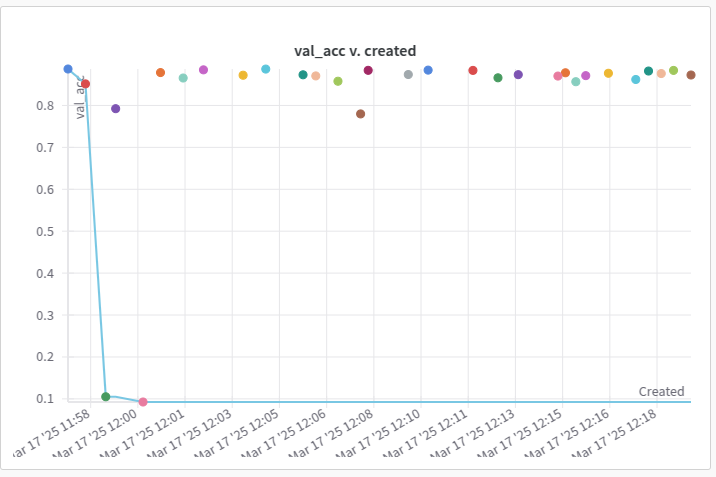

Question 6 (20 Marks)
Based on the different experiments that you have run we want you to make some inferences about which configurations worked and which did not.

Here again, wandb automatically generates a "Parallel co-ordinates plot" and a "correlation summary" as shown below. Learn about a "Parallel co-ordinates plot" and how to read it.

By looking at the plots that you get, write down some interesting observations (simple bullet points but should be insightful). You can also refer to the plot in Question 5 while writing these insights. For example, in the above sample plot there are many configurations which give less than 65% accuracy. I would like to zoom into those and see what is happening.

I would also like to see a recommendation for what configuration to use to get close to 95% accuracy.

![image.png](attachment:image.png)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: ch24s016 (ch24s016-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


<Run ch24s016-iitm/fashion_mnist_sweep/fb9d9r7d (finished)>
Best run ID: fb9d9r7d, Val Accuracy: 0.8856666666666667
the best model parameters are {'epochs': 10, 'optimizer': 'nadam', 'activation': 'tanh', 'batch_size': 32, 'hidden_size': 128, 'weight_init': 'xavier', 'weight_decay': 0.0005, 'hidden_layers': 4, 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.4700, Train Acc: 0.8295, Val Loss: 0.3825, Val Acc: 0.8590
Epoch 2/10 - Train Loss: 0.3710, Train Acc: 0.8643, Val Loss: 0.3581, Val Acc: 0.8692
Epoch 3/10 - Train Loss: 0.3373, Train Acc: 0.8744, Val Loss: 0.3448, Val Acc: 0.8770
Epoch 4/10 - Train Loss: 0.3162, Train Acc: 0.8824, Val Loss: 0.3329, Val Acc: 0.8765
Epoch 5/10 - Train Loss: 0.2998, Train Acc: 0.8888, Val Loss: 0.3339, Val Acc: 0.8815
Epoch 6/10 - Train Loss: 0.2847, Train Acc: 0.8936, Val Loss: 0.3310, Val Acc: 0.8787
Epoch 7/10 - Train Loss: 0.2756, Train Acc: 0.8976, Val Loss: 0.3322, Val Acc: 0.8757
Epoch 8/10 - Train Loss: 0.2671, Train Acc: 0.9013, Val Loss: 

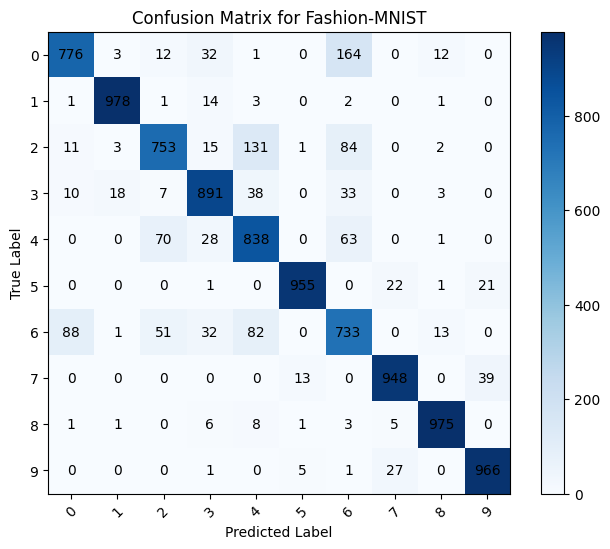

In [7]:

wandb.login()
wandb.init()
api = wandb.Api()

# Fetch all runs in the sweep
sweep_runs = api.sweep(f"ch24s016-iitm/fashion_mnist_sweep/2xv177pr").runs

# Find the best model based on validation accuracy
best_run = max(sweep_runs, key=lambda run: run.summary.get("val_acc", 0))

print(best_run)

print(f"Best run ID: {best_run.id}, Val Accuracy: {best_run.summary.get('val_acc', 0)}")

print('the best model parameters are',best_run.config)


model = NeuralNetwork(
       input_neurons=784,
       hidden_layers=[best_run.config['hidden_size']] * best_run.config['hidden_layers'],
       output_neurons=10,
       optimizer=best_run.config['optimizer'],
       learning_rate=best_run.config['learning_rate'],
       init_wb_method=best_run.config['weight_init'],
       weight_decay = best_run.config['weight_decay'],
       activation=best_run.config['activation'],
       beta1=0.9,
       beta2=0.999
   )

model.train(train_images_splitted, train_labels_splitted, best_run.config['epochs'], best_run.config['batch_size'], val_images, val_labels,plots=False,wb_log=True)

y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(test_labels, axis=1)
test_accuracy = np.mean(y_pred == y_true_labels)
print('the accuracy of test dataset is ',test_accuracy)

# Number of classes in Fashion-MNIST
num_classes = 10

# Initialize confusion matrix with zeros
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Populate the confusion matrix
for true, pred in zip(y_true_labels, y_pred):
    confusion_matrix[true, pred] += 1


    
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(confusion_matrix, cmap="Blues")

# Add color bar
plt.colorbar(cax)

# Set labels
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(np.arange(num_classes))
ax.set_yticklabels(np.arange(num_classes))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add text annotations inside the cells
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, str(confusion_matrix[i, j]), ha="center", va="center", color="black")

# Set title
ax.set_title("Confusion Matrix for Fashion-MNIST")

# Show plot
plt.show()


To Verify that our confusion Matrix is correct we are going to compare the accuracy with computed confusion matrix Vs our Manually Computed Accuracy

In [8]:
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(test_labels, axis=1)
test_accuracy = np.mean(y_pred == y_true_labels)
print('the accuracy of test dataset is ',test_accuracy)


# Print the confusion matrix in a readable format
print("Confusion Matrix:")
for row in confusion_matrix:
    print(" ".join(f"{val:5d}" for val in row))
    
correct_predictions = sum(confusion_matrix[i][i] for i in range(num_classes))

# Compute total predictions (sum of all elements)
total_predictions = sum(sum(row) for row in confusion_matrix)

# Calculate accuracy
accuracy = correct_predictions / total_predictions

# Print accuracy
print("Computed Test Accuracy:", accuracy)

[[8.22400096e-08 2.08117871e-06 6.89672053e-08 ... 1.48624197e-03
  3.17164673e-07 9.98472861e-01]
 [1.71150455e-03 4.54370250e-06 9.86688795e-01 ... 6.26444056e-05
  1.45482268e-05 2.46021187e-06]
 [2.15428230e-06 9.99950343e-01 3.46521935e-06 ... 1.81425804e-06
  1.18722812e-06 1.84975023e-07]
 ...
 [6.48387927e-06 3.11032814e-07 1.16483798e-06 ... 2.98234949e-06
  9.99817427e-01 9.66301604e-07]
 [1.52212997e-06 9.98939078e-01 3.69244103e-06 ... 6.03119722e-06
  6.32023904e-05 1.09441555e-05]
 [2.89590674e-07 1.58249144e-07 5.50172757e-06 ... 1.52913592e-04
  2.01387248e-05 2.20368891e-05]]
the accuracy of test dataset is  0.8813
Confusion Matrix:
  776     3    12    32     1     0   164     0    12     0
    1   978     1    14     3     0     2     0     1     0
   11     3   753    15   131     1    84     0     2     0
   10    18     7   891    38     0    33     0     3     0
    0     0    70    28   838     0    63     0     1     0
    0     0     0     1     0   955     0 

Question 8 (5 Marks)


In all the models above you would have used cross entropy loss. Now compare the cross entropy loss with the squared error loss. I would again like to see some automatically generated plots or your own plots to convince me whether one is better than the other.

Added squared_error in neural network code on 4TH Question Part                
                
    if loss_function == "cross_entropy":
        loss = -np.sum(y_batch * np.log(predictions + 1e-8)) / len(y_batch)  # Avoid log(0)
    elif loss_function == "squared_error":
        loss = np.sum((y_batch - predictions) ** 2) / len(y_batch)
    total_loss += loss

On our best model I am going to run the model with both cross entropy and squared error and let compare how accuracies are coming...

In [15]:
wandb.login()
wandb.init()
api = wandb.Api()

# Fetch all runs in the sweep
sweep_runs = api.sweep(f"ch24s016-iitm/fashion_mnist_sweep/2xv177pr").runs

# Find the best model based on validation accuracy
best_run = max(sweep_runs, key=lambda run: run.summary.get("val_acc", 0))

print(best_run)

print(f"Best run ID: {best_run.id}, Val Accuracy: {best_run.summary.get('val_acc', 0)}")

print('the best model parameters are',best_run.config)


model = NeuralNetwork(
       input_neurons=784,
       hidden_layers=[best_run.config['hidden_size']] * best_run.config['hidden_layers'],
       output_neurons=10,
       optimizer=best_run.config['optimizer'],
       learning_rate=best_run.config['learning_rate'],
       init_wb_method=best_run.config['weight_init'],
       weight_decay = best_run.config['weight_decay'],
       activation=best_run.config['activation'],
       beta1=0.9,
       beta2=0.999
   )

model.train(train_images_splitted, train_labels_splitted, best_run.config['epochs'], best_run.config['batch_size'], val_images, val_labels,loss_function='cross_entropy',plots=False,wb_log=True)

y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(test_labels, axis=1)
test_accuracy = np.mean(y_pred == y_true_labels)
print('the accuracy of test dataset with Cross Entropy Loss ',test_accuracy)


model.train(train_images_splitted, train_labels_splitted, best_run.config['epochs'], best_run.config['batch_size'], val_images, val_labels,loss_function='squared_error',plots=False,wb_log=True)

y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(test_labels, axis=1)
test_accuracy = np.mean(y_pred == y_true_labels)
print('the accuracy of test dataset with Squared Error Loss ',test_accuracy)



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


<Run ch24s016-iitm/fashion_mnist_sweep/fb9d9r7d (finished)>
Best run ID: fb9d9r7d, Val Accuracy: 0.8856666666666667
the best model parameters are {'epochs': 10, 'optimizer': 'nadam', 'activation': 'tanh', 'batch_size': 32, 'hidden_size': 128, 'weight_init': 'xavier', 'weight_decay': 0.0005, 'hidden_layers': 4, 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.4667, Train Acc: 0.8304, Val Loss: 0.3817, Val Acc: 0.8633
Epoch 2/10 - Train Loss: 0.3696, Train Acc: 0.8649, Val Loss: 0.3692, Val Acc: 0.8700
Epoch 3/10 - Train Loss: 0.3361, Train Acc: 0.8770, Val Loss: 0.3663, Val Acc: 0.8612
Epoch 4/10 - Train Loss: 0.3156, Train Acc: 0.8844, Val Loss: 0.3512, Val Acc: 0.8722
Epoch 5/10 - Train Loss: 0.2994, Train Acc: 0.8884, Val Loss: 0.3419, Val Acc: 0.8765
Epoch 6/10 - Train Loss: 0.2871, Train Acc: 0.8936, Val Loss: 0.3187, Val Acc: 0.8845
Epoch 7/10 - Train Loss: 0.2760, Train Acc: 0.8980, Val Loss: 0.3660, Val Acc: 0.8645
Epoch 8/10 - Train Loss: 0.2671, Train Acc: 0.8996, Val Loss: 

In [13]:
wandb.login()
wandb.init()
api = wandb.Api()

# Fetch all runs in the sweep
sweep_runs = api.sweep(f"ch24s016-iitm/fashion_mnist_sweep/2xv177pr").runs

# Find the best model based on validation accuracy
best_run = max(sweep_runs, key=lambda run: run.summary.get("val_acc", 0))

print(best_run)

print(f"Best run ID: {best_run.id}, Val Accuracy: {best_run.summary.get('val_acc', 0)}")

print('the best model parameters are',best_run.config)


model = NeuralNetwork(
       input_neurons=784,
       hidden_layers=[best_run.config['hidden_size']] * best_run.config['hidden_layers'],
       output_neurons=10,
       optimizer=best_run.config['optimizer'],
       learning_rate=best_run.config['learning_rate'],
       init_wb_method=best_run.config['weight_init'],
       weight_decay = best_run.config['weight_decay'],
       activation='softmax',
       beta1=0.9,
       beta2=0.999
   )

model.train(train_images_splitted, train_labels_splitted, best_run.config['epochs'], best_run.config['batch_size'], val_images, val_labels,loss_function='cross_entropy',plots=False,wb_log=True)

y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(test_labels, axis=1)
test_accuracy = np.mean(y_pred == y_true_labels)
print('the accuracy of test dataset with Cross Entropy Loss ',test_accuracy)


model.train(train_images_splitted, train_labels_splitted, best_run.config['epochs'], best_run.config['batch_size'], val_images, val_labels,loss_function='squared_error',plots=False,wb_log=True)

y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(test_labels, axis=1)
test_accuracy = np.mean(y_pred == y_true_labels)
print('the accuracy of test dataset with Squared Error Loss ',test_accuracy)



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


<Run ch24s016-iitm/fashion_mnist_sweep/fb9d9r7d (finished)>
Best run ID: fb9d9r7d, Val Accuracy: 0.8856666666666667
the best model parameters are {'epochs': 10, 'optimizer': 'nadam', 'activation': 'tanh', 'batch_size': 32, 'hidden_size': 128, 'weight_init': 'xavier', 'weight_decay': 0.0005, 'hidden_layers': 4, 'learning_rate': 0.001}


KeyError: 1